# Laboratorio 2 — Clasificación: detección de eventos raros (dataset sintético)

Aprenderás a diseñar un pipeline de clasificación y a evaluar correctamente cuando hay desbalance de clases.

## Objetivos
- Generar o cargar datos y entender el desbalance.
- Entrenar un baseline lineal y un modelo de ensamble.
- Usar métricas adecuadas (F1, matriz de confusión, ROC-AUC) y umbrales.

## Requisitos
- Laboratorio 0
- scikit-learn


## Contexto

Muchos problemas de IA en industria son *detección de eventos raros*: fraude, fallos, intrusiones, etc.
En estos escenarios **Accuracy** puede engañar: si el 98% es clase negativa, un modelo que siempre diga “no” ya logra 98%.


## 1) Crear un dataset con desbalance

Usaremos `make_classification` para simular datos tabulares sin depender de descargas externas.


In [ ]:
import numpy as np
import pandas as pd

"""
make_classification -> Genera datos de ejemplo para clasificación supervisada
"""
from sklearn.datasets import make_classification

X, y = make_classification(
    # n_samples=6000 → 6000 observaciones
    n_samples=6000,
    # n_features=20 → 20 variables
    n_features=20,
    # n_informative=6 → solo 6 realmente ayudan a predecir
    n_informative=6,
    # n_redundant=2 → combinaciones lineales de otras
    n_redundant=2,
    # n_clusters_per_class=2 → Cada clase está formada por 2 “grupos” de datos
    n_clusters_per_class=2,
    # weights=[0.97, 0.03] → 97% de clase 0, 3% de clase 1 → evento raro
    weights=[0.97, 0.03],  # 3% positivos
    # flip_y=0.01 → 1% de etiquetas incorrectas
    flip_y=0.01,
    # random_state=42 → resultados reproducibles
    random_state=42
)

"""
x = ahora es un DataFrame
"""
X = pd.DataFrame(X, columns=[f"f{i:02d}" for i in range(X.shape[1])])
"""
y = ahora es un Series llamada evento raro
"""
y = pd.Series(y, name="evento_raro")

"""
Cuenta proporciones de cada clase
"""
y.value_counts(normalize=True)


evento_raro
0    0.967
1    0.033
Name: proportion, dtype: float64

## 2) Split + baseline

Empezamos con regresión logística (con escalado).


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

"""
test_size=0.2 → 80% entrenamiento, 20% test
stratify=y -> mantiene el mismo porcentaje de clases
random_state=42 → garantiza que siempre se divida igual.
"""
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

"""
StandardScaler -> Media 0, desviación 1
LogisticRegression -> class_weight="balanced"
    Penaliza más los errores en la clase rara

"max_iter=500" → máximo de iteraciones para que el modelo converja
"class_weight='balanced'" → da más peso a la clase rara, evitando que el modelo ignore los 3% positivos
"""
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=500, class_weight="balanced"))
])

"""
Entrenas todo en una sola línea
"""
pipe_lr.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not wo

## 3) Métricas que importan

Además de F1, observaremos:
- Matriz de confusión
- Curva ROC y AUC
- Precisión/Recall

La pregunta clave: **¿prefieres falsos positivos o falsos negativos?** Depende del negocio.


              precision    recall  f1-score   support

           0      0.987     0.814     0.892      1160
           1      0.115     0.700     0.197        40

    accuracy                          0.810      1200
   macro avg      0.551     0.757     0.545      1200
weighted avg      0.958     0.810     0.869      1200

ROC-AUC: 0.8248275862068966


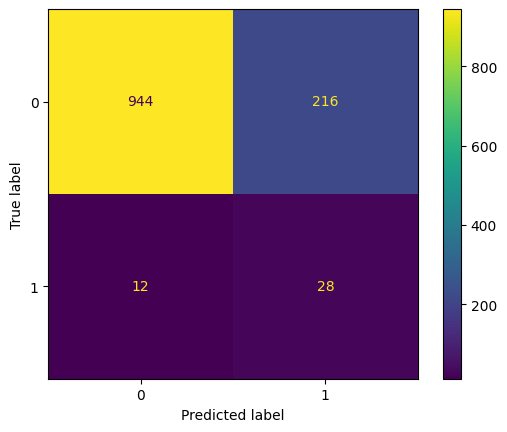

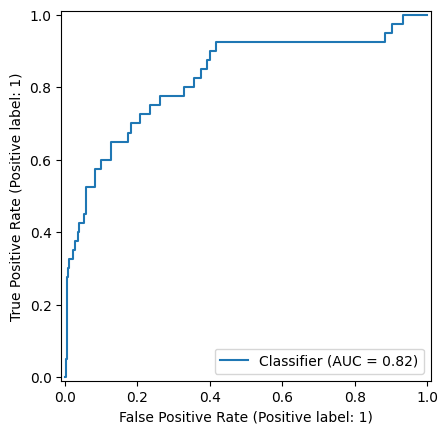

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

"""
predict → clase final
predict_proba → probabilidad del evento raro

y_pred → predicciones finales (0/1)
y_proba → probabilidad de clase 1 (evento raro)
"""
y_pred = pipe_lr.predict(X_test)
y_proba = pipe_lr.predict_proba(X_test)[:, 1]

"""
Precision = TP / (TP + FP) → porcentaje de predicciones positivas correctas
Recall = TP / (TP + FN) → porcentaje de positivos detectados
F1-score = media armónica de precision y recall → útil en clases desbalanceadas

precision → qué tan confiables son los positivos
recall → cuántos positivos reales detectas
f1-score → balance entre ambos
"""
print(classification_report(y_test, y_pred, digits=3))

"""
ROC-AUC mide capacidad de discriminación, independiente del umbral
0.5 → aleatorio, 1 → perfecto
"""
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

"""
Matriz de confusión 
"""
cm = confusion_matrix(y_test, y_pred)
"""
Visualización
"""
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

"""
Curva ROC
    Evalúa el tradeoff entre:
        Tasa de verdaderos positivos
        Falsos positivos
"""
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.show()


## 4) Modelo alternativo: Gradient Boosting

Los modelos de boosting suelen rendir muy bien en tabular. Aquí probamos `HistGradientBoostingClassifier`.


In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

"""
Modelo no lineal, suele funcionar mejor con datos complejos
Basado en árboles de decisión

max_depth=6 → profundidad máxima de cada árbol
learning_rate=0.08 → paso de aprendizaje
random_state=42 → reproducible
"""
gb = HistGradientBoostingClassifier(
    max_depth=6,
    learning_rate=0.08,
    random_state=42
)
gb.fit(X_train, y_train)


"""
Predicción de clases y probabilidades
"""
y_pred_gb = gb.predict(X_test)
y_proba_gb = gb.predict_proba(X_test)[:, 1]

"""
Evaluación
"""
print(classification_report(y_test, y_pred_gb, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_gb))


              precision    recall  f1-score   support

           0      0.981     0.998     0.989      1160
           1      0.895     0.425     0.576        40

    accuracy                          0.979      1200
   macro avg      0.938     0.712     0.783      1200
weighted avg      0.978     0.979     0.976      1200

ROC-AUC: 0.9008405172413793


## 5) Ajuste de umbral

Por defecto, muchos clasificadores usan umbral 0.5. Con clases desbalanceadas, conviene seleccionar el umbral por una métrica objetivo (p.ej., maximizar F1 o asegurar recall mínimo).


In [ ]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

"""
Pruebas muchos umbrales distintos.
"""
thresholds = np.linspace(0.05, 0.95, 19)

rows = []
for t in thresholds:
    # convierte probabilidades en clases según el umbral t
    pred_t = (y_proba_gb >= t).astype(int)
    rows.append({
        "umbral": t,
        "precision": precision_score(y_test, pred_t, zero_division=0),
        "recall": recall_score(y_test, pred_t),
        "f1": f1_score(y_test, pred_t, zero_division=0),
    })

df = pd.DataFrame(rows).sort_values("f1", ascending=False)
df.head(10)


,umbral,precision,recall,f1
2,0.15,0.766667,0.575,0.657143
3,0.20,0.814815,0.550,0.656716
1,0.10,0.718750,0.575,0.638889
4,0.25,0.833333,0.500,0.625000
0,0.05,0.615385,0.600,0.607595
5,0.30,0.826087,0.475,0.603175
6,0.35,0.826087,0.475,0.603175
7,0.40,0.826087,0.475,0.603175
8,0.45,0.818182,0.450,0.580645
9,0.50,0.894737,0.425,0.576271


## Ejercicios

### Ejercicio 1: Métrica orientada a negocio
Define un coste para FP y FN (por ejemplo, FP=1, FN=10). Encuentra el umbral que minimiza el coste esperado.

**Entregables**
- Función de coste
- Tabla coste vs umbral
- Umbral óptimo y justificación

**Criterios de evaluación**
- El coste se calcula correctamente
- Se justifica el umbral con números
- Se discute el trade-off


In [6]:

# Definir costes
cost_FP = 1
cost_FN = 10

# Umbrales a probar
thresholds = np.linspace(0.05, 0.95, 19)

costes = []

for t in thresholds:
    # Predicción según umbral
    pred_t = (y_proba_gb >= t).astype(int)
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, pred_t)
    TN, FP, FN, TP = cm.ravel()
    
    # Coste total
    coste_total = FP * cost_FP + FN * cost_FN
    
    # Guardamos
    costes.append({
        "umbral": t,
        "FP": FP,
        "FN": FN,
        "coste_total": coste_total
    })

# Convertir a DataFrame y ver resultados
df_coste = pd.DataFrame(costes)
df_coste.sort_values("coste_total")


print(df_coste.head(10))  # ver los 10 umbrales con menor coste


   umbral  FP  FN  coste_total
0    0.05  15  16          175
1    0.10   9  17          179
2    0.15   7  17          177
3    0.20   5  18          185
4    0.25   4  20          204
5    0.30   4  21          214
6    0.35   4  21          214
7    0.40   4  21          214
8    0.45   4  22          224
9    0.50   2  23          232


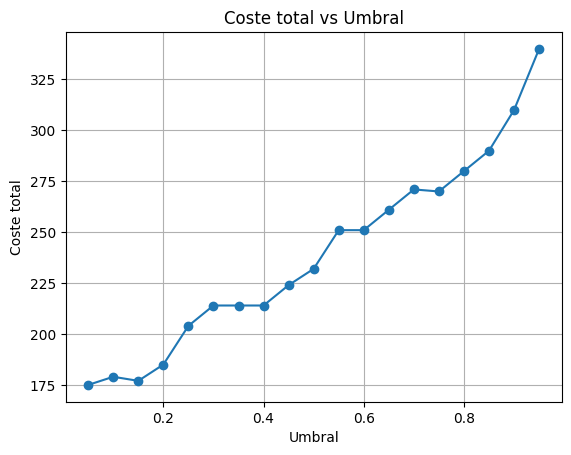

In [7]:
import matplotlib.pyplot as plt

plt.plot(df_coste["umbral"], df_coste["coste_total"], marker='o')
plt.xlabel("Umbral")
plt.ylabel("Coste total")
plt.title("Coste total vs Umbral")
plt.grid(True)
plt.show()


### Ejercicio 2: Comparación de modelos
Añade un tercer modelo (p.ej., `RandomForestClassifier` o `SVC`) y compáralo con LR y GB usando las mismas métricas.

**Entregables**
- Tabla comparativa
- Conclusión

**Pistas**
- En desbalance, prueba `class_weight='balanced'` o muestreo si procede

**Criterios de evaluación**
- Comparación justa (mismo split)
- Métricas relevantes
- Conclusión argumentada


In [8]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,       # número de árboles
    max_depth=8,            # profundidad máxima
    class_weight='balanced', # crucial para clases desbalanceadas
    random_state=42
)

# Entrenar el modelo
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]  # Probabilidad de clase 1

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

metrics = {}

for name, y_pred, y_proba in [
    ("LR", y_pred, y_proba),
    ("GB", y_pred_gb, y_proba_gb),
    ("RF", y_pred_rf, y_proba_rf)
]:
    metrics[name] = {
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_proba)
    }

# Convertir a tabla
df_metrics = pd.DataFrame(metrics).T
print(df_metrics)
"""
Precision → porcentaje de positivos predichos que son correctos
Recall → porcentaje de positivos reales detectados
F1 → balance precision/recall
ROC-AUC → capacidad de discriminar clase positiva vs negativa

En datasets desbalanceados:
Recall suele ser más importante si los FN son costosos (como fraude o fallos)
Precision importante si FP es costoso
F1 o ROC-AUC ayudan a comparar globalmente


Conclusión
    Al mirar la tabla:
        Compara cuál modelo tiene:
            Mayor F1 → mejor balance
            Mayor Recall → detecta más eventos raros
            ROC-AUC alto → mejor discriminación

    Discute trade-offs (mejores modelos o peores modelos):
        Random Forest (RF) suele ser más robusto con relaciones no lineales
        Gradient Boosting (GB) puede superar en F1 o ROC-AUC con tuning fino
        Regresión Logística (LR) puede ser suficiente si las relaciones son lineales y buscas interpretabilidad
"""

    precision  recall        f1   roc_auc
LR   0.114754   0.700  0.197183  0.824828
GB   0.894737   0.425  0.576271  0.900841
RF   0.720000   0.450  0.553846  0.930453
